# Full regional extraction
Here we will extract cells from a variable size continuous polygon.
This will be the first step in doing a full regionalising model.
> For simplicity we restrict the list to only one polygon

In [49]:
#Loading things as usual
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Ok, the approach will be this
1. Let $p=(x,y)$ in Mexico
2. Create a buffer size list (maybe exponential) not to big.
4. Generate a list of polygons according to this list.
5. Overlay with the mesh (lowest resolution)
6. Extract cells, or cell ids.


In [50]:
from django.contrib.gis.geos import Point, Polygon
xcoord = -99.76
ycoord = 17.55
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,1, 10)
polys = map(lambda r : p.buffer(r),radii)


In [51]:
## Intersect the polygons with the cells to obtain the targets

In [52]:
from mesh.models import initMesh

In [53]:
mexmesh = initMesh(11)

DEBUG Changed MESH TABLE SPACE


In [54]:
## restrict the polygons to the polygon n 3
polys = [polys[0]]
intersected_cells = map(lambda poly : mexmesh.objects.filter(cell__intersects=poly),polys)

In [55]:
# Number of selected cells in each buffer
values = map(lambda l : list(l.values_list('id',flat=True)),intersected_cells)

In [56]:
## Change to network database
from traversals.strategies import idsToCells
cells = map(lambda level : list(idsToCells(level)),values)

INFO Compiling Query and asking the Graph Database


In [57]:
### Sumon the LToL
# Following example from Data generator
from drivers.tree_builder import buildTreeNeo
trees = []
for list_of_cells in cells:
    %time trees.append(map(lambda c : buildTreeNeo(c),list_of_cells))


CPU times: user 1min 33s, sys: 2.75 s, total: 1min 36s
Wall time: 1min 44s


In [58]:
## Pseudo Presence bursea 
from traversals import strategies as st
## Get all models, environmental variables
from raster_api.models import raster_models_dic

In [59]:
rstmods = raster_models_dic.keys()

In [60]:
%time data = map(lambda cell : st.getEnvironmentalCovariatesFromListOfCells(cell,vars=rstmods),cells)

CPU times: user 604 ms, sys: 28 ms, total: 632 ms
Wall time: 8.83 s


## Let's build the Pseudo presence absence
First, Let be bursera the node we want to model

In [61]:
bursera = pickNode(Family,'Burseracea')

In [62]:
root_node = bursera.getParent().getParent().getParent().getParent().getParent()

In [63]:
presences = []
for ltree in trees:
    %time presences.append(st.getPresencesForNode(root_node,ltree))
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.36 ms


In [64]:
from utilities import data_extraction as de
centers_nested = map(lambda c : map(lambda p : p.centroid, c),cells)
from ecoregions.models import TerrEcoregions,InegiIV

In [65]:
## Calculate tipo de vegetacion
#vegie_types = map(lambda lp : extractVegetation(lp),centers_nested)
from ecoregions.models import TerrEcoregions,InegiIV
vectsel = [[TerrEcoregions,['wwf_mhtnum','wwf_mhtnam'],[np.nan,'NaN']],[InegiIV,['covid','name'],[np.nan,'NaN']]]
vegie_types = map(lambda lp : de.extractSeveralVectorFeatures(lp,vectsel),centers_nested)

INFO extracting info from: <class 'ecoregions.models.TerrEcoregions'> this can take some minutes
INFO extracting info from: <class 'ecoregions.models.InegiIV'> this can take some minutes


In [66]:
datos = zip(presences,data,vegie_types)

In [67]:
## Compile the dataframe and convert to geopandas
dd = map(lambda (p,d,v) : pd.concat([p,d,v],axis=1),datos)
dd = map(lambda d : st.toGeoDataFrame(d,xcoord_name='Longitude',ycoord_name='Latitude'),dd)

In [68]:
#for i,d in enumerate(dd):
#    cad = '/outputs/presence_only_models/data/root_p3/%s.csv'%i
#    print(cad)
#    d.to_csv(cad,encoding='utf8')

In [69]:
d = dd[0]

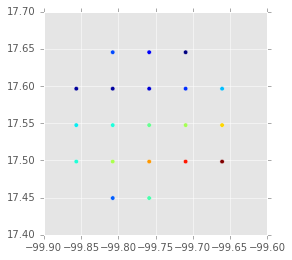

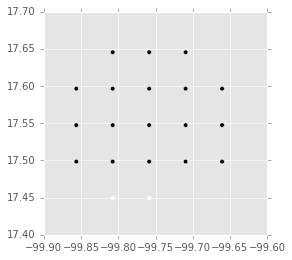

In [70]:
d.plot(column='Dist.to.road_m')
d.plot(column='LUCA',cmap=plt.cm.Greys)

In [71]:
## Let's save it in Redis
import redis
import pickle
conn = redis.StrictRedis(host='redis',password='biospytial.')

In [72]:
tag = 't-guerrero-p0'
conn.set(tag,pickle.dumps(d))

True